In [1]:
from lstm_module import LSTM_SS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/shail/Desktop/project/raw data/Device-4.csv')

df.columns = ['SNo','temp','hum','co','no2','pm2_5','pm10','date']
date = df['date']
df = df.drop(["SNo"],axis=1)
df['date'] = pd.to_datetime(df['date'])
#df.index.freq='MS'

In [3]:
df = df[(df['co'] > 0) & (df['no2'] > 0) & (df['pm2_5'] > 0) & (df['pm10'] > 0)]

In [4]:
temp_one_hr = round(df.resample('60min',on='date').temp.mean(),2)
hum_one_hr = round(df.resample('60min',on='date').hum.mean(),2)
co_one_hr = round(df.resample('60min',on='date').co.mean(),2)
no2_one_hr = round(df.resample('60min',on='date').no2.mean(),2)
pm2_5_one_hr = round(df.resample('60min',on='date').pm2_5.mean(),2)
pm10_one_hr = round(df.resample('60min',on='date').pm10.mean(),2)

one_hr_sample = pd.DataFrame({
    "TEMP":temp_one_hr,
    "HUM":hum_one_hr,
    "CO":co_one_hr,
    "NO2":no2_one_hr,
    "PM2.5":pm2_5_one_hr,
    "PM10":pm10_one_hr
})

one_hr_sample

,TEMP,HUM,CO,NO2,PM2.5,PM10
date,,,,,,
2019-09-13 16:00:00,17.69,61.16,6.32,19.40,32.73,45.76
2019-09-13 17:00:00,16.80,67.48,6.43,19.40,38.32,53.31
2019-09-13 18:00:00,17.00,66.82,6.21,19.40,27.65,38.68
2019-09-13 19:00:00,16.40,63.55,5.78,19.39,22.28,31.30
2019-09-13 20:00:00,15.73,66.26,6.06,19.39,22.89,31.97
...,...,...,...,...,...,...
2020-01-11 13:00:00,16.18,44.28,44.00,1.32,78.92,109.69
2020-01-11 14:00:00,20.59,31.49,44.00,1.27,65.24,90.83
2020-01-11 15:00:00,19.94,31.55,44.00,1.20,54.23,75.30


In [5]:
pm = one_hr_sample[['PM2.5']].copy()

In [6]:
pm

,PM2.5
date,
2019-09-13 16:00:00,32.73
2019-09-13 17:00:00,38.32
2019-09-13 18:00:00,27.65
2019-09-13 19:00:00,22.28
2019-09-13 20:00:00,22.89
...,...
2020-01-11 13:00:00,78.92
2020-01-11 14:00:00,65.24
2020-01-11 15:00:00,54.23


In [7]:
df = pm.copy()

In [8]:
df.isna().sum()

PM2.5    1157
dtype: int64

In [9]:
df = df.interpolate(method ='linear')

<AxesSubplot:xlabel='date'>

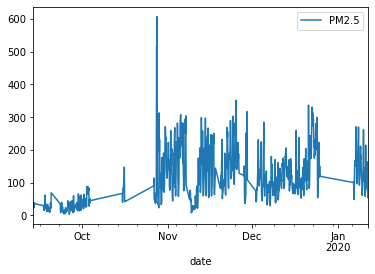

In [10]:
df.plot()

In [11]:
len(df)

2882

In [12]:
train = df.iloc[:2858]
test = df.iloc[2858:]

scaler = MinMaxScaler()

In [13]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

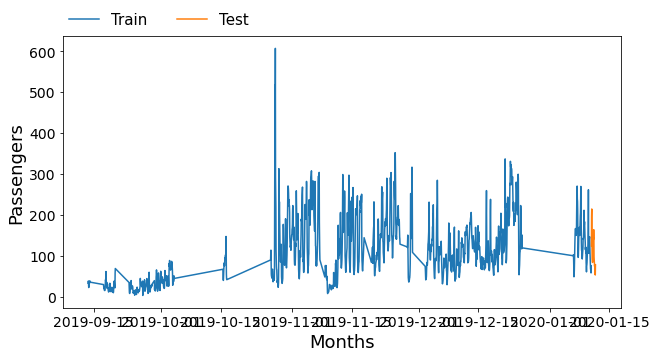

In [14]:
plt.figure(figsize=(10, 5))

plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')

plt.xlabel('Months', fontsize=18)
plt.ylabel('Passengers', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3, 
           borderaxespad=0, frameon=False, prop={"size":15})

plt.show()


In [15]:
n_input = 24
n_features = 1

def generate_data(data, n_input):
    X, y = [], []
    for i in range(0,len(data)-n_input):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input])
    return np.array(X), np.array(y)

X, y = generate_data(scaled_train, n_input)

# Original LSTM

In [16]:
model = Sequential()
model.add(LSTM(200, input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(X, y, epochs=50, verbose=0)

In [18]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.1460203], dtype=float32),
 array([0.15831044], dtype=float32),
 array([0.16432357], dtype=float32),
 array([0.16890672], dtype=float32),
 array([0.17236489], dtype=float32),
 array([0.17317571], dtype=float32),
 array([0.17035785], dtype=float32),
 array([0.16393453], dtype=float32),
 array([0.15517354], dtype=float32),
 array([0.14737692], dtype=float32),
 array([0.14329073], dtype=float32),
 array([0.14391702], dtype=float32),
 array([0.14864187], dtype=float32),
 array([0.1552172], dtype=float32),
 array([0.16079724], dtype=float32),
 array([0.16307002], dtype=float32),
 array([0.1616939], dtype=float32),
 array([0.15740618], dtype=float32),
 array([0.1515908], dtype=float32),
 array([0.14558516], dtype=float32),
 array([0.1404208], dtype=float32),
 array([0.1366837], dtype=float32),
 array([0.13467734], dtype=float32),
 array([0.13454518], dtype=float32)]

In [19]:
true_predictions = scaler.inverse_transform(test_predictions)

test['original_LSTM'] = true_predictions

<AxesSubplot:xlabel='date'>

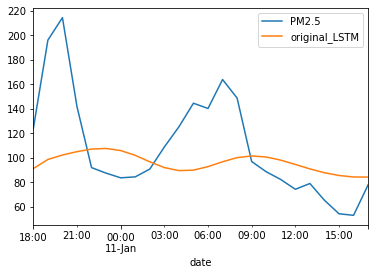

In [20]:
test.plot()

In [21]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['original_LSTM']))
print(rmse)

42.35260793586555


In [22]:
test

,PM2.5,original_LSTM
date,,
2020-01-10 18:00:00,123.76,91.100195
2020-01-10 19:00:00,195.89,98.522094
2020-01-10 20:00:00,214.24,102.153360
2020-01-10 21:00:00,141.64,104.921078
2020-01-10 22:00:00,91.89,107.009434
2020-01-10 23:00:00,87.37,107.499078
2020-01-11 00:00:00,83.57,105.797404
2020-01-11 01:00:00,84.33,101.918423
2020-01-11 02:00:00,90.69,96.627749


# SELF_MADE_LSTM

In [23]:
self_model = LSTM_SS(1, 1, 200, n_input, 0.01)

In [24]:
self_model.fit(50, X, y, verbose=False)

In [25]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = self_model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.16868773]),
 array([0.16826841]),
 array([0.17212917]),
 array([0.1762491]),
 array([0.19018952]),
 array([0.17938771]),
 array([0.1761429]),
 array([0.18628472]),
 array([0.19206958]),
 array([0.19314262]),
 array([0.19298491]),
 array([0.19487735]),
 array([0.17340346]),
 array([0.16752673]),
 array([0.1834173]),
 array([0.18738547]),
 array([0.19967854]),
 array([0.1694262]),
 array([0.15726054]),
 array([0.22744389]),
 array([0.22769394]),
 array([0.18384055]),
 array([0.18428946]),
 array([0.18860127])]

In [26]:
true_predictions = scaler.inverse_transform(test_predictions)

test['SELF_MADE_LSTM'] = true_predictions

<AxesSubplot:xlabel='date'>

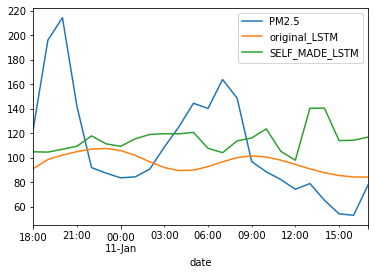

In [27]:
test.plot()

In [28]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['SELF_MADE_LSTM']))
print(rmse)

46.740693385943814


In [29]:
test

,PM2.5,original_LSTM,SELF_MADE_LSTM
date,,,
2020-01-10 18:00:00,123.76,91.100195,104.788832
2020-01-10 19:00:00,195.89,98.522094,104.535609
2020-01-10 20:00:00,214.24,102.153360,106.867082
2020-01-10 21:00:00,141.64,104.921078,109.355067
2020-01-10 22:00:00,91.89,107.009434,117.773547
2020-01-10 23:00:00,87.37,107.499078,111.250445
2020-01-11 00:00:00,83.57,105.797404,109.290937
2020-01-11 01:00:00,84.33,101.918423,115.415478
2020-01-11 02:00:00,90.69,96.627749,118.908899
